# Machine Learning Engineer Nanodegree
## Unsupervised Learning
## Project: Creating Customer Segments

## Goal

In this project, I will analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.



In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print("Wholesale customers dataset has {} samples with {} features each.".format(*data.shape))
except:
    print("Dataset could not be loaded. Is the dataset missing?")

Wholesale customers dataset has 440 samples with 6 features each.


## Data Exploration
In this section, I will explore the data through visualizations and code to understand how each feature is related to the others. 

In [12]:
# Display a description of the dataset
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. 

In [2]:
# Select three indices to sample from the dataset
indices = [136, 365, 419]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print("Chosen samples of wholesale customers dataset:")
display(samples)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,4625,8579,7030,4575,2447,1542
1,4692,6128,8025,1619,4515,3105
2,8861,3783,2223,633,1580,1521


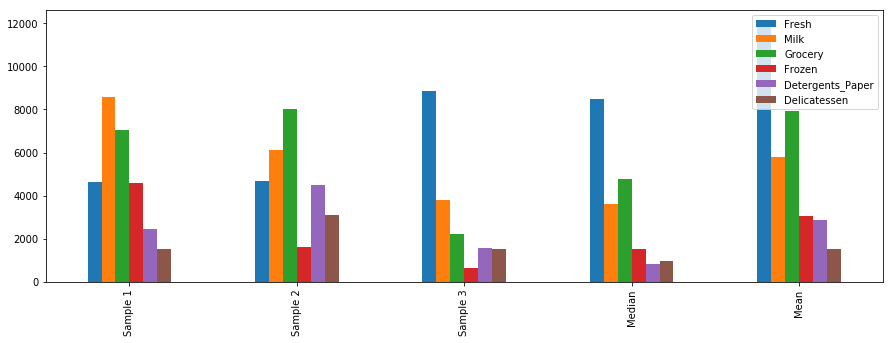

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
samples_for_plot = samples.copy()
samples_for_plot.loc[3] = data.median()
samples_for_plot.loc[4] = data.mean()

labels = ['Sample 1', 'Sample 2', 'Sample 3', 'Median', 'Mean']
samples_for_plot.plot(kind='bar', figsize=(15, 5))
plt.xticks(range(5), labels)
plt.show()

In [8]:
display(samples.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,6059.333333,6163.333333,5759.333333,2275.666667,2847.333333,2056.000000
std,2426.545762,2398.195224,3102.699846,2051.401797,1507.897985,908.521326
min,4625.000000,3783.000000,2223.000000,633.000000,1580.000000,1521.000000
25%,4658.500000,4955.500000,4626.500000,1126.000000,2013.500000,1531.500000
50%,4692.000000,6128.000000,7030.000000,1619.000000,2447.000000,1542.000000
75%,6776.500000,7353.500000,7527.500000,3097.000000,3481.000000,2323.500000
max,8861.000000,8579.000000,8025.000000,4575.000000,4515.000000,3105.000000


### Question 1
Consider the total purchase cost of each product category and the statistical description of the dataset above for your sample customers.  

* What kind of establishment (customer) could each of the three samples you've chosen represent?

**Hint:** Examples of establishments include places like markets, cafes, delis, wholesale retailers, among many others. Avoid using names for establishments, such as saying *"McDonalds"* when describing a sample customer as a restaurant. You can use the mean values for reference to compare your samples with. The mean values are as follows:

* Fresh: 12000.2977
* Milk: 5796.2
* Grocery: 3071.9
* Detergents_paper: 2881.4
* Delicatessen: 1524.8

Knowing this, how do your samples compare? Does that help in driving your insight into what kind of establishments they might be? 


**Answer:**
The mean values of the samples are as follows: 

- Fresh: 6059.3	
- Milk: 6163.3
- Grocery: 5759.3		
- Detergents_paper: 2847.3
- Delicatessen: 2056.0

Compared with the above establishment, these samples used less fresh food while using more grocery and delicatessen. This help in driving my insight into that they might be delis. 

### Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? I can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.


In [4]:
# Make a copy of the DataFrame, using the 'drop' function to drop the given feature
new_data = data.drop(['Detergents_Paper'], axis = 1)

# Split the data into training and testing sets(0.25) using the given feature as the target
# Set a random state.
from sklearn.cross_validation import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(new_data, data['Detergents_Paper'], test_size = 0.25, random_state = 46)

# Create a decision tree regressor and fit it to the training set
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state = 56)
regressor = regressor.fit(X_train, y_train)

# Report the score of the prediction using the testing set
score = regressor.score(X_test, y_test)
print('The score of the prediction is:', score)

The score of the prediction is: 0.667954313279


/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Here I attempted to predict if customers would buy detergents paper while buying products of other categories (i.e., fresh produce, milk, grocery, frozen products, and delicatessens). The score of this prediction is about 0.668, which means the prediction explains 66.8% of the variance. This relatively high value of prediction score suggests that this feature is relatively easy to predict using other features, therefore, it is considered not necessary for identifying customers' spending habbits. 

In [4]:
# Make a copy of the DataFrame, using the 'drop' function to drop the given feature
new_data = data.drop(['Milk'], axis = 1)

# Split the data into training and testing sets(0.25) using the given feature as the target
# Set a random state.
from sklearn.cross_validation import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(new_data, data['Milk'], test_size = 0.25, random_state = 46)

# Create a decision tree regressor and fit it to the training set
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state = 56)
regressor = regressor.fit(X_train, y_train)

# Report the score of the prediction using the testing set
score = regressor.score(X_test, y_test)
print('The score of the prediction is:',score)

The score of the prediction is: 0.1423055905


In this section, I attempted to predict the buying habbit of milk. The prediction score is only 0.142 suggests that this explains 14.2% of the variance, meaning that this feature is hard to predict using other features. Therefore, the category of 'Milk' is necessary for identifying customers' spending habits. 

In [3]:
# Make a copy of the DataFrame, using the 'drop' function to drop the given feature
new_data = data.drop(['Grocery'], axis = 1)

# Split the data into training and testing sets(0.25) using the given feature as the target
# Set a random state.
from sklearn.cross_validation import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(new_data, data['Grocery'], test_size = 0.25, random_state = 46)

# Create a decision tree regressor and fit it to the training set
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state = 56)
regressor = regressor.fit(X_train, y_train)

# Report the score of the prediction using the testing set
score = regressor.score(X_test, y_test)
print('The score of the prediction is:',score)

The score of the prediction is: 0.634869423945


/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In this section, I attempted to predict if customers would buy grocery when buying products from all other categories. The prediction score is 0.635 suggests that it explains about 63.5% of the variance. This relatively high value of prediction score suggests that this feature is relatively easy to predict using other features, therefore, it is considered not necessary for identifying customers' spending habbits. 

In [6]:
# Make a copy of the DataFrame, using the 'drop' function to drop the given feature
new_data = data.drop(['Delicatessen'], axis = 1)

# Split the data into training and testing sets(0.25) using the given feature as the target
# Set a random state.
from sklearn.cross_validation import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(new_data, data['Delicatessen'], test_size = 0.25, random_state = 46)

# Create a decision tree regressor and fit it to the training set
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state = 56)
regressor = regressor.fit(X_train, y_train)

# Report the score of the prediction using the testing set
score = regressor.score(X_test, y_test)
print('The score of the prediction is:',score)

The score of the prediction is: 0.421804715032


Similarly, I here attempted to predict whether customers would by delicatessens when they are buying products of other categories. The prediction score is about 0.422, which explains about 42.2% of the variance. Although it fits some of the data, compared to the previous feature--'Milk', this score is not as low. Therefore, I don't consider this feature to be necessary for identifying customers' spending habbit. 

In [7]:
# Make a copy of the DataFrame, using the 'drop' function to drop the given feature
new_data = data.drop(['Frozen'], axis = 1)

# Split the data into training and testing sets(0.25) using the given feature as the target
# Set a random state.
from sklearn.cross_validation import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(new_data, data['Frozen'], test_size = 0.25, random_state = 46)

# Create a decision tree regressor and fit it to the training set
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state = 56)
regressor = regressor.fit(X_train, y_train)

# Report the score of the prediction using the testing set
score = regressor.score(X_test, y_test)
print('The score of the prediction is:',score)

The score of the prediction is: -0.634661137613


In [8]:
# Make a copy of the DataFrame, using the 'drop' function to drop the given feature
new_data = data.drop(['Fresh'], axis = 1)

# Split the data into training and testing sets(0.25) using the given feature as the target
# Set a random state.
from sklearn.cross_validation import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(new_data, data['Fresh'], test_size = 0.25, random_state = 46)

# Create a decision tree regressor and fit it to the training set
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state = 56)
regressor = regressor.fit(X_train, y_train)

# Report the score of the prediction using the testing set
score = regressor.score(X_test, y_test)
print('The score of the prediction is:',score)

The score of the prediction is: -1.26347774795


In these two above sections, I attempted to predict if customers would purchase frozen products and if customers would purchase fresh produce when buying products of other categories, respectively. Both prediction scores are negative values, indicating that these two models fail to fit the data. 

### Question 2

* Which feature did you attempt to predict? 
* What was the reported prediction score? 
* Is this feature necessary for identifying customers' spending habits?

The coefficient of determination, `R^2`, is scored between 0 and 1, with 1 being a perfect fit. A negative `R^2` implies the model fails to fit the data. If you get a low score for a particular feature, that lends us to beleive that that feature point is hard to predict using the other features, thereby making it an important feature to consider when considering relevance.

**Answer:**
Please see answers above. 

### Visualize Feature Distributions
To get a better understanding of the dataset, I constructed a scatter matrix of each of the six product features present in the data. If the feature attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if the feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  


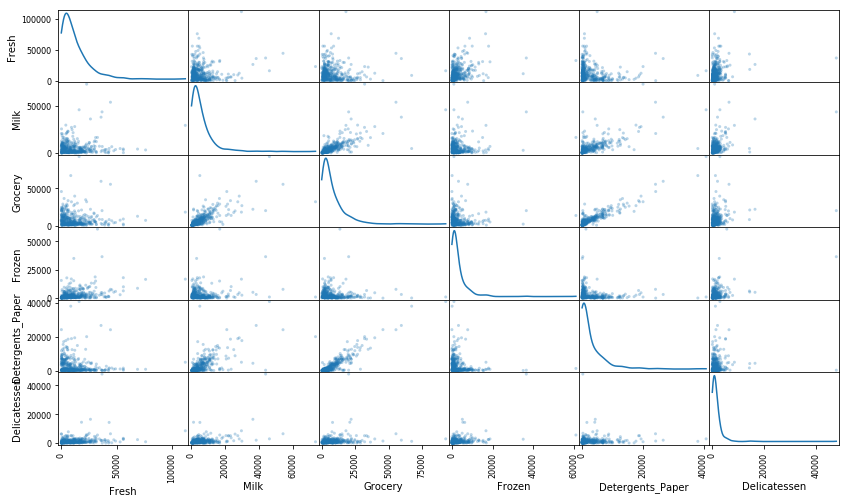

In [4]:
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Question 3
* Using the scatter matrix as a reference, discuss the distribution of the dataset, specifically talk about the normality, outliers, large number of data points near 0 among others. If you need to sepearate out some of the plots individually to further accentuate your point, you may do so as well.
* Are there any pairs of features which exhibit some degree of correlation? 
* Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? 
* How is the data for those features distributed?



In [7]:
data.corr()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Fresh,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicatessen,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000


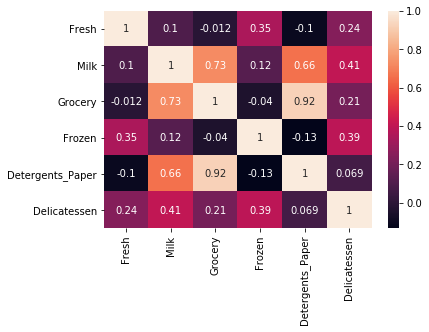

In [5]:
import seaborn as sns
sns.heatmap(data.corr(), annot=True)

**Answer:**
- The data is not normally distributed, with most data points lie in 10,000.
- From the above correlation heatmap, these following pairs show some higher degree correlation:
    - milk & grocery
    - milk & detergents_paper
    - grocery & detergents_paper
- From the correlation results and the heatmap above, it confirms my suspicion that the category of milk can be considered as necessary for identifying customers' spending habbit given that it has correlations with every category. Similarly, 'Fresh' and 'Frozen' do not have strong correlations with other categories, therefore are not considered to be necessary for identifying customers' spending habbit.    

## Data Preprocessing
In this section, you will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results you obtain from your analysis are significant and meaningful.

###  Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  


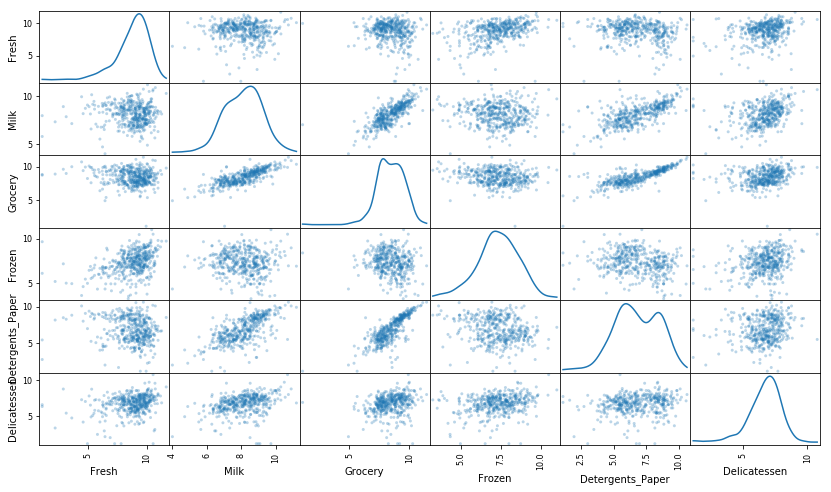

In [6]:
# Scale the data using the natural logarithm
log_data = np.log(data)

# Scale the sample data using the natural logarithm
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features I have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).



In [9]:
# Display the log-transformed sample data
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,8.439232,9.057073,8.857942,8.428362,7.802618,7.340836
1,8.453614,8.720624,8.990317,7.389564,8.415160,8.040769
2,9.089415,8.238273,7.706613,6.450470,7.365180,7.327123


### Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, I will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.


In [9]:
# For each feature find the data points with extreme high or low values
for feature in log_data.keys():
    
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data, 25)
    
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data, 75)
    
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5*(Q3 - Q1)
    
    # Display the outliers
    print("Data points considered outliers for the feature '{}':".format(feature))
    display(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))])
    
# OPTIONAL: Select the indices for data points  to remove
outliers  = [75, 66, 338, 142, 154]

# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
338,1.098612,5.808142,8.856661,9.655090,2.708050,6.309918


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
122,9.410174,5.303305,5.501258,7.596392,3.218876,6.756932
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101
177,9.453992,8.899731,8.419139,7.468513,2.995732,7.875119
204,7.578657,6.792344,8.561401,7.232010,1.609438,7.191429
237,9.835851,8.252707,6.385194,8.441176,3.332205,7.102499
289,10.663966,5.655992,6.154858,7.235619,3.465736,3.091042
338,1.098612,5.808142,8.856661,9.655090,2.708050,6.309918


Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372
233,6.871091,8.513988,8.106515,6.842683,6.013715,1.945910


### Question 4
* Are there any data points considered outliers for more than one feature based on the definition above? 
* Should these data points be removed from the dataset? 
* If any data points were added to the `outliers` list to be removed, explain why.


**Answer:**

- The data point:
    - 75 has outliers for more than one feature: both 'Grocery' and 'Detergents_Paper'
    - 66 has outliers for more than one feature: both 'Fresh' and 'Delicatessen'
    - 338 has outliers for more than one feature: both 'Fresh' and 'Detergents_Paper'
    - 142 and 154 have outliers for more than one feature: both 'Detergents_Paper' and 'Delicatessen'
    
- These data point should be remove from the dataset because it can reduce overlap in memberships during clustering. 

## Feature Transformation
In this section I use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, I will find which compound combinations of features best describe customers.

### PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, I can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.


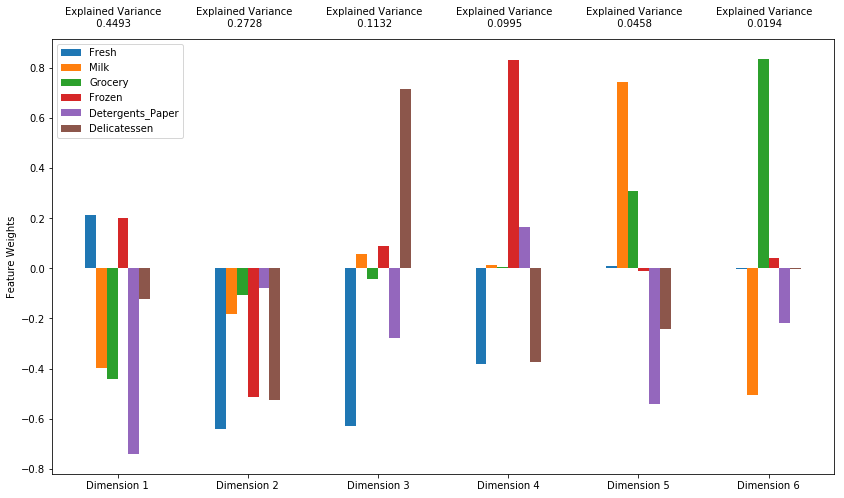

In [10]:
from sklearn.decomposition import PCA
# Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(n_components = 6)
pca.fit(good_data)

# Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = vs.pca_results(good_data, pca)

In [9]:
# DataFrame of results
display(pca_results)

# DataFrame
display(type(pca_results))

# Cumulative explained variance should add to 1
display(pca_results['Explained Variance'].cumsum())

,Explained Variance,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Dimension 1,0.4476,0.1808,-0.4044,-0.4421,0.1665,-0.7441,-0.1640
Dimension 2,0.2749,-0.6435,-0.1556,-0.0763,-0.5286,-0.0291,-0.5250
Dimension 3,0.1135,-0.6083,0.0129,-0.0757,0.0247,-0.2681,0.7427
Dimension 4,0.0970,0.4277,-0.0315,-0.0113,-0.8305,-0.1308,0.3302
Dimension 5,0.0480,-0.0130,0.7332,0.3305,-0.0266,-0.5618,-0.1915
Dimension 6,0.0189,-0.0074,-0.5229,0.8268,0.0418,-0.2023,0.0128


pandas.core.frame.DataFrame

Dimension 1    0.4476
Dimension 2    0.7225
Dimension 3    0.8360
Dimension 4    0.9330
Dimension 5    0.9810
Dimension 6    0.9999
Name: Explained Variance, dtype: float64

### Question 5

* How much variance in the data is explained* **in total** *by the first and second principal component? 
* How much variance in the data is explained by the first four principal components? 
* Using the visualization provided above, talk about each dimension and the cumulative variance explained by each, stressing upon which features are well represented by each dimension(both in terms of positive and negative variance explained). Discuss what the first four dimensions best represent in terms of customer spending.


**Answer:**
- The first principal component explained 43.61% of the variance while the second principal component explained 71.79% of the variance. 
- The first four principal components explained 93.38% of the variance. 
- Components breakdown:
    - The first principal component (PC1):
    An increase in PC1 is associated with large increases in "Milk", "Grocery" and "Detergents_Paper" spending.
    These features best represent PC1.
    This is in line with our initial findings where the 3 features are highly correlated.
    -The second principal component (PC2):
        - An increase in PC2 is associated with large increases in "Fresh", "Frozen" and "Delicatessen" spending.
        - These features best represent PC2.
        - This makes sense as PC1 represents different features. And in PC2, the features in PC1 have very small positive weights.
    - The third principal component (PC3):
            - An increase in PC3 is associated with a large increase in "Delicatessen" and a large decrease in "Fresh" spending.
        - These features best represent PC3.
    - The fourth principal component (PC4):
        - An increase in PC4 is associated with a large increasing in "Frozen" and a large decrease in "Delicatessen" spending.
        - These features best represent PC4.

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. Observe the numerical value for the first four dimensions of the sample points. Consider if this is consistent with your initial interpretation of the sample points.

In [12]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3
0,-1.0145,-0.5920,0.0
1,-0.4876,0.7487,0.0
2,1.5020,-0.1568,0.0


### Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.


,Explained Variance,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Dimension 1,0.4493,0.2131,-0.3972,-0.4407,0.200,-0.7403,-0.1207
Dimension 2,0.2728,-0.6419,-0.1814,-0.1069,-0.513,-0.0769,-0.5240


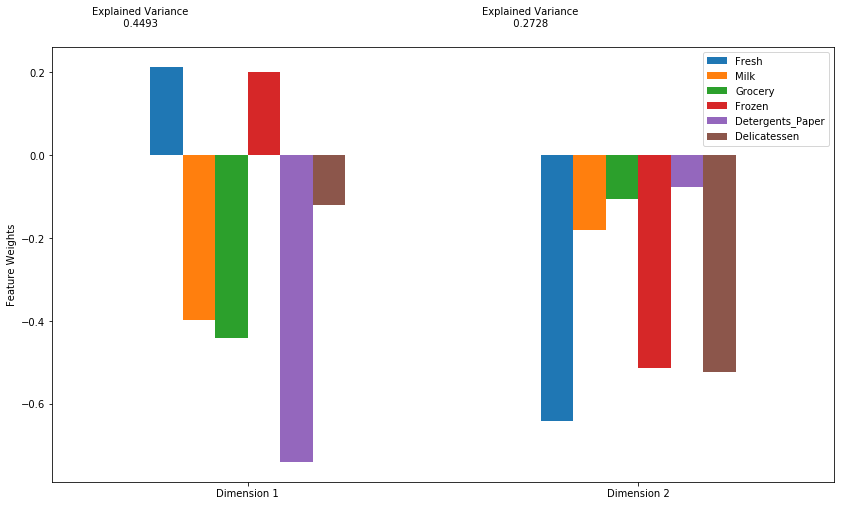

In [11]:
# Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components = 2)
pca.fit(good_data)
# Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])
vs.pca_results(good_data, pca)

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [10]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,-1.2739,-0.9451
1,-1.9374,-0.7483
2,-0.3178,-0.0828


## Visualizing a Biplot
A biplot is a scatterplot where each data point is represented by its scores along the principal components. The axes are the principal components (in this case `Dimension 1` and `Dimension 2`). In addition, the biplot shows the projection of the original features along the components. A biplot can help us interpret the reduced dimensions of the data, and discover relationships between the principal components and original features.



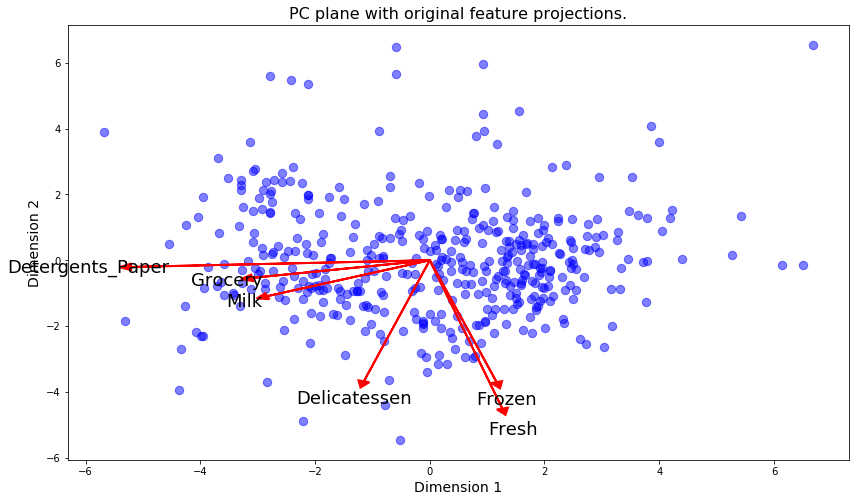

In [11]:
# Create a biplot
vs.biplot(good_data, reduced_data, pca)

### Observation

Once we have the original feature projections (in red), it is easier to interpret the relative position of each data point in the scatterplot. For instance, a point the lower left corner of the figure will likely correspond to a customer that spends a lot on `'Milk'`, `'Grocery'` and `'Detergents_Paper'`, but not so much on the other product categories. 

From the biplot, which of the original features are most strongly correlated with the first component? What about those that are associated with the second component? Do these observations agree with the pca_results plot you obtained earlier?

**Answer:**

From the biplot, 'Fresh', 'Frozen', and 'Delicatessen' are the most strongly correlated with the first component while all other features are strongly associated with the second component. These observations agree with the pca_results plot I obtained earlier. 

## Clustering

In this section, I will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. I will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Question 6

* What are the advantages to using a K-Means clustering algorithm? 
* What are the advantages to using a Gaussian Mixture Model clustering algorithm? 
* Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?

** Hint: ** Think about the differences between hard clustering and soft clustering and which would be appropriate for our dataset.

**Answer:**

- The advantages to using a K-Means clustering algorithm are: 
   - Easy to implement
   - With a large number of variables, K-Means may be computationally faster (if K is small)
           
           
- The Advantages to using a Gaussian Mixture Model clustering algorithm include: 
   - It is the fastest algorithm for learning mixture models
   - As this algorithm maximizes only the likelihood, it will not bias the means towards zero, or bias the cluster sizes to have specific structures that might or might not apply.
   - There is a 'soft' classification available 
   - It has the flexibility in choosing the component distribution 
   - It can obtain a density estimation for each cluster
   
   
- For this customer dataset, I will choose Gaussian Mixture Model clustering algorithm. The whole sale customer data seems to have some overlaps between categories, which may pose some challenges to using K-Means clustering due to its hard clustering mechanism that only allows spherical distribution of points in a cluster. Gaussian Mixture Model clustering algorithm on the other hand has a soft clustering mechanism that allows rotated and/or elongated distribution of points in a cluster. In addition, Gaussian Mixture Model clustering allows mixed memberships, meaning a point belongs to each cluster to a different degree. This is more avantagous over K-Means clustering where a point belongs to one and ONLY one cluster. 

###  Creating Clusters
Depending on the problem, the number of clusters that one expects to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, I can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.


In [13]:
# Create range of clusters 
range_n_clusters = list(range(2,11))
print(range_n_clusters)

[2, 3, 4, 5, 6, 7, 8, 9, 10]


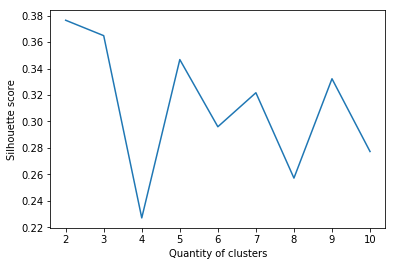

The best cluster number is 2 with a silhouette score of 0.37650378096356335


In [20]:
# Apply Gaussian Mixture Model clustering algorithm to the reduced data 
from sklearn.mixture import GaussianMixture 
from sklearn.cluster import KMeans
from sklearn import metrics
# Loop through clusters
clusters_scores = []
for clusters in np.arange(2,11):
    # Apply clustering algorithm of choice to the reduced data 
    clusterer = GaussianMixture(n_components=clusters).fit(reduced_data)

    # Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # Find the cluster centers
    centers = clusterer.means_

    # Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(pca_samples)

    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = metrics.silhouette_score(reduced_data, preds, metric='mahalanobis')
    clusters_scores.append(score)
    #setting for the best score 
    best_cluster = clusters_scores.index(max(clusters_scores)) + 2
    clusterer = KMeans(n_clusters = best_cluster).fit(reduced_data)
    preds = clusterer.predict(reduced_data)
    sample_preds = clusterer.predict(pca_samples)
    centers = clusterer.cluster_centers_
#plot the graph of silhouette scores 
plt.plot(np.arange(2,11), clusters_scores)
plt.xlabel('Quantity of clusters')
plt.ylabel('Silhouette score')
plt.show()

print ("The best cluster number is {} with a silhouette score of {}".format(best_cluster, max(clusters_scores)))

### Question 7

* Report the silhouette score for several cluster numbers you tried. 
* Of these, which number of clusters has the best silhouette score?

**Answer:**

- Below are the sihouette scores obtained from the codes above:
    - 2 clusters: 0.416077700559
    - 3 clusters: 0.395523512591
    - 4 clusters: 0.284436221367
    - 5 clusters: 0.263150583668
    - 6 clusters: 0.314834293681
- Two clusters has the best silhouette score. 

### Cluster Visualization


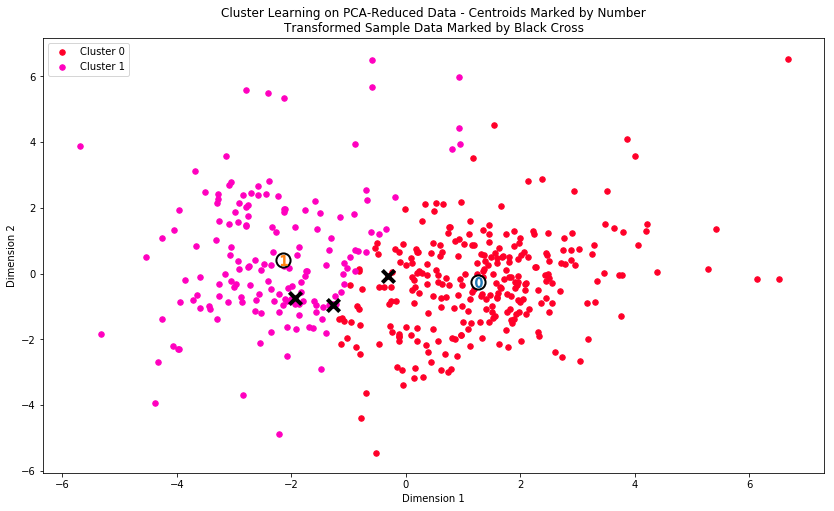

In [9]:
# Display the results of the clustering from implementation
vs.cluster_results(reduced_data, preds, centers, pca_samples)

### Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, I can recover the representative customer spending from these data points by applying the inverse transformations.


In [10]:
# Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,9416.0,2120.0,2744.0,2083.0,355.0,734.0
Segment 1,3289.0,7561.0,11739.0,826.0,4390.0,898.0


### Question 8

* Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project(specifically looking at the mean values for the various feature points). What set of establishments could each of the customer segments represent?


**Answer:**

- Compared with the mean values for the various feature points, segment 0 could represent retailers. 
- Compared with the mean values for the various feature points, segment 1 could represent hotel/restaurants/cafes. 

In [13]:
#inverse the transformation on samples 
true_samples = np.exp(log_samples)
display(true_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,4625.0,8579.0,7030.0,4575.0,2447.0,1542.0
1,4692.0,6128.0,8025.0,1619.0,4515.0,3105.0
2,8861.0,3783.0,2223.0,633.0,1580.0,1521.0


### Question 9

* For each sample point, which customer segment from* **Question 8** *best represents it? 
* Are the predictions for each sample point consistent with this?*



In [11]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print("Sample point", i, "predicted to be in Cluster", pred)

Sample point 0 predicted to be in Cluster 1
Sample point 1 predicted to be in Cluster 1
Sample point 2 predicted to be in Cluster 0


**Answer:**

- From the displayed result above, I categorize those sample points as follows:
    - Sample point 0: Segment 0 
    - Sample point 1: segment 0 
    - Sample point 2: segment 1
- From the prediction results above, the predictions are consistent with the conclusion above. 


## Conclusion

In this final section, I will investigate ways that I can make use of the clustered data. First, I will consider how the different groups of customers, the ***customer segments***, may be affected differently by a specific delivery scheme. Next, I will consider how giving a label to each customer (which *segment* that customer belongs to) can provide for additional features about the customer data. Finally, I will compare the ***customer segments*** to a hidden variable present in the data, to see whether the clustering identified certain relationships.

### Question 10
Companies will often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services to determine whether making that change will affect its customers positively or negatively. The wholesale distributor is considering changing its delivery service from currently 5 days a week to 3 days a week. However, the distributor will only make this change in delivery service for customers that react positively. 

* How can the wholesale distributor use the customer segments to determine which customers, if any, would react positively to the change in delivery service?*



**Answer:**
- Impact on customers in segment 0:
    - This group of customers would be affected the most 
    - This is because they consume more 'Fresh' products that are perishable, such as meat, fruit, and seafood
- Impact on customers in segment 1: 
    - The impact on this group due to the change in delivery service should be minimal 
    - This is because this group of customers consume mostly 'Grocery' and 'Detergent_Paper' products that are NOT perishable and are shelf-stable
    - This impact can be complicated by the consumption of 'Milk' products because 'Milk' products are perishable
    - Although this group of customers also consume more 'Milk' products than those of segment 0, the impact of the change in delivery service can also be minimal because 'Milk' products have longer shelf-life
- Measure impact:
    - The wholesale distributor can conduct a Control & Study group experiment to measure the impact on the customers due to the change of delivery services
    - Random sampling: the distributor can randomly select customers from each segment and randomly assign them to either Control Group or Study Group. Each group consists of the same number of customers. 
    - Implementation: Customers in Control Group will receive the current 5 days a week delivery service while customers in the Study Group will receive 3 days a week delivery service. 
    - Duration of experiment: It can be set to 3-4 weeks.
    - Measure tools: 
        - Customer satisfaction survey: using a scale of 1-5, asks customers about their satisfaction on the delivery service. For study group, asks them about how the change affects their business, such as were they able to order sufficient amount of products to operate. 
        - Spending records: Compare spending between control group and study group
    - Measures: 
        - Identify customers with low-level of satisfactions and correlate with their spending records 
        - Evaluate the correlation between satisfaction and spending

### Question 11
Additional structure is derived from originally unlabeled data when using clustering techniques. Since each customer has a ***customer segment*** it best identifies with (depending on the clustering algorithm applied), we can consider *'customer segment'* as an **engineered feature** for the data. Assume the wholesale distributor recently acquired ten new customers and each provided estimates for anticipated annual spending of each product category. Knowing these estimates, the wholesale distributor wants to classify each new customer to a ***customer segment*** to determine the most appropriate delivery service.  
* How can the wholesale distributor label the new customers using only their estimated product spending and the **customer segment** data?



**Answer:**

- For the supervised learning model, we will need to use labeled data. Here is when the customer segment data come in handy because we have all old customers' spending data with their segment labels. This data set can be then divided into training and testing set. The training set will be used to train the supervised learning model while using the testing set for testing. The supervised learning model will then learn from this data and can make predictions using new customers spending data.
- Target variable would be the cluster group.

### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier to the original dataset.

Run the code block below to see how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` the reduced space. In addition, you will find the sample points are circled in the plot, which will identify their labeling.

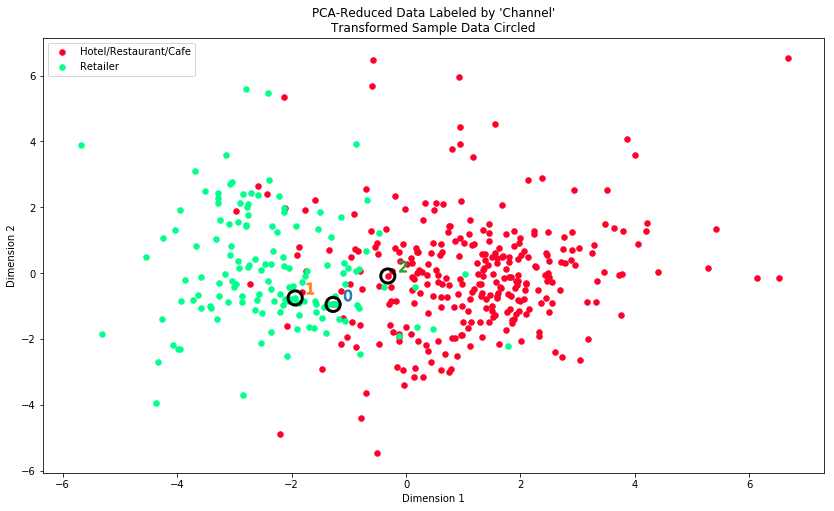

In [27]:
# Display the clustering results based on 'Channel' data
vs.channel_results(reduced_data, outliers, pca_samples)

### Question 12

* How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? 
* Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? 
* Would you consider these classifications as consistent with your previous definition of the customer segments?

**Answer:**

- The number of clusters is consistent with the underlying distribution with 2 major clusters hence the clustering algorithm did well.
- There are customer segments that would be purely classified as "Retailers" or "Hotels/"Restaurants/Cafes" on the extreme left and right accordingly.
- This underlying classification is consistent with our observation where we noted cluster 0 customers are typically restaurants and cafes and cluster 1 customers are typically markets.